In this notebook we model the relationships between variables from the Austin weather and bikeshare datasets. Specifically, we use the method of linear least squares to model these relationships.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import thinkplot
import thinkstats2

%matplotlib inline
sns.set()

## below code taken from Thinkstats2 repo notebook: chap10ex
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

# Read in bikeshare data

In [2]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

df['start_time'] = pd.to_datetime(df['start_time'])

df['date'] = df['start_time'].dt.date

# Read in weather data

In [3]:
# read in data from a csv file
weather_df = pd.read_csv('../Data/austin_weather.csv')

# Replace values with NaNs
weather_df.replace('-', np.nan, inplace=True)
weather_df.replace('T', np.nan, inplace=True)

# Convert column types to float
for col in weather_df:
    if col != 'Date' and col != 'Events':
        weather_df[[col]] = weather_df[[col]].astype(float)
        
# Convert the column type to the datetime type
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
# Set the index to that column
weather_df.index = weather_df['Date']

In [4]:
def get_merged_data(aggregation=None):
    """
    Return bikeshare data merged with weather data.
    
    aggregation: One of {None, 'mean', 'median'}
        Reduce the number of rows by performing some aggregation by day on the duration column.
    """
    if aggregation is None:
        _df = df[['date', 'duration_minutes']].copy()
        _df['date'] = pd.to_datetime(_df['date'])
        _df_weather = weather_df.copy()
        _df = _df.merge(_df_weather, how='left', left_on='date', right_on='Date')
    elif aggregation == 'mean':
        _df = df[['start_time', 'duration_minutes']].copy()
        _df.index = _df['start_time']
        _df = _df.resample('D').mean()
        _df = _df.join(weather_df)
    elif aggregation == 'median':
        _df = df[['start_time', 'duration_minutes']].copy()
        _df.index = _df['start_time']
        _df = _df.resample('D').median()
        _df = _df.join(weather_df)
    else:
        raise Error
        
    return _df

In a previous [notebook](https://github.com/lpatruno/stats-fall17/blob/master/notebooks/Lecture%209%20-%20Scatter%20Plots%20%26%20Correlation.ipynb), we saw that there was a correlation between the daily average temperature and daily average bike duration. 

Let's create a scatter plot of these two variables - average daily temperature and average daily bike duration - and perform a linear least squares fit to come up with a line relating the two variables.

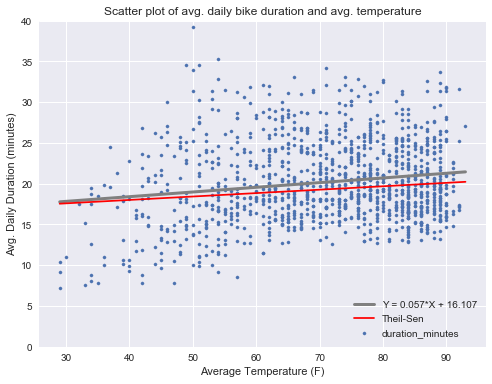

Pearson:  0.163333553581
Spearman:  0.115690208372 

Y = 0.057*X + 16.107


In [5]:
# Merge the two datasets
_df = get_merged_data(aggregation='mean')
# Drop rows for days that had no bike rides
_df = _df.dropna(subset=['duration_minutes'])

# TODO explain the Theil-Sen estimator
res = stats.theilslopes(_df['duration_minutes'], _df['TempAvgF'], 0.90)

# Perform a linear least squares fit
inter, slope = LeastSquares(_df['TempAvgF'], _df['duration_minutes'])
fit_xs, fit_ys = FitLine(_df['TempAvgF'], inter, slope)

plt.figure(figsize=(8, 6))
plt.scatter(_df['TempAvgF'], _df['duration_minutes'], s=10)
plt.plot(fit_xs, fit_ys, color='gray', linewidth=3,
        label='Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))
plt.plot(fit_xs, res[1] + res[0]*fit_xs, color='red',
        label='Theil-Sen')

plt.title('Scatter plot of avg. daily bike duration and avg. temperature')
plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Average Temperature (F)')
plt.legend(loc='lower right')
plt.ylim([0,40])

plt.show()

print('Pearson: ', _df[['TempAvgF', 'duration_minutes']].corr().loc['TempAvgF', 'duration_minutes'])
print('Spearman: ', _df[['TempAvgF', 'duration_minutes']].corr(method='spearman').loc['TempAvgF', 'duration_minutes'], '\n')
print('Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))


In [16]:
res = Residuals(_df['TempAvgF'], _df['duration_minutes'], inter, slope)
r2 = CoefDetermination(_df['duration_minutes'], res)
r2

0.026677849725319169

In [13]:
# Include some comment about this
inter + slope * _df['TempAvgF'].mean()

20.186423908834204

The calculated slope of .057 indicates that the average daily bike ride duration increase by .057 minutes - or about 3.45 seconds - for each degree increase in the daily average temperature.

In [21]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        x, y = data
        _, slope = thinkstats2.LeastSquares(x, y)
        return slope

    def MakeModel(self):
        _, y = self.data
        self.ybar = y.mean()
        self.res = y - self.ybar

    def RunModel(self):
        x, _ = self.data
        y = self.ybar + np.random.permutation(self.res)
        return x, y
    
ht = SlopeTest((_df['TempAvgF'], _df['duration_minutes']))
pvalue = ht.PValue()
pvalue

0.0

The p-value indicates that our slope is statistically significant.

By examining the scatter plot, we notice that the correlation is higher on days where the average daily temperature was lower than 60 degrees. Let's repeat our regression analysis for days when the average daily temperature is less than 60 degrees.

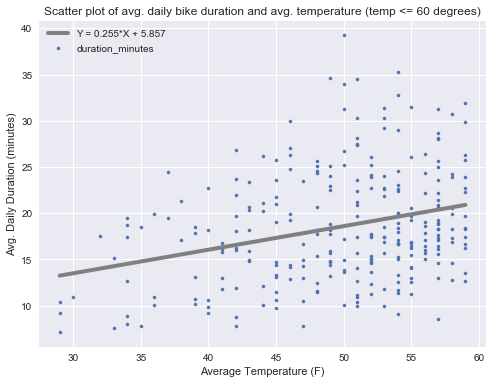

Pearson:  0.294664938578
Spearman:  0.253934591414 

Y = 0.255*X + 5.857


In [18]:
sub_60_df = _df[_df['TempAvgF'] < 60]

inter, slope = LeastSquares(sub_60_df['TempAvgF'], sub_60_df['duration_minutes'])
fit_xs, fit_ys = FitLine(sub_60_df['TempAvgF'], inter, slope)

plt.figure(figsize=(8, 6))
plt.scatter(sub_60_df['TempAvgF'], sub_60_df['duration_minutes'], s=10)
plt.plot(fit_xs, fit_ys, color='gray', linewidth=4,
        label='Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))

plt.title('Scatter plot of avg. daily bike duration and avg. temperature (temp <= 60 degrees)')
plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Average Temperature (F)')
plt.legend(loc='upper left')
plt.show()

print('Pearson: ', sub_60_df[['TempAvgF', 'duration_minutes']].corr().loc['TempAvgF', 'duration_minutes'])
print('Spearman: ', sub_60_df[['TempAvgF', 'duration_minutes']].corr(method='spearman').loc['TempAvgF', 'duration_minutes'], '\n')
print('Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))

The correlation between daily average temperature and daily average ride duration is on days where the average daily temperature was less than or equal to 60 degrees is .295, about an 80% increase.

The calculated slope is also larger - .255 - indicating that the average daily bike ride duration increased by .255 minutes - or about 15.3 seconds - for each degree increase in the daily average temperature.

However, we're regressing on much less data in this case.

In [158]:
print('Total number of days: {}'.format(len(_df)))
print('Number of days where temp <= 60 degrees: {}'.format(len(sub_60_df)))

Total number of days: 1257
Number of days where temp <= 60 degrees: 272


In [19]:
res = Residuals(sub_60_df['TempAvgF'], sub_60_df['duration_minutes'], inter, slope)
r2 = CoefDetermination(sub_60_df['duration_minutes'], res)
r2

0.086827426027113686

What if we used the daily low or high temperature instead of the average? 

Let's compute the correlations for these variables.

In [160]:
for col in ['TempHighF', 'TempLowF', 'TempAvgF']:
    print(col)
    print('Pearson: ', _df[[col, 'duration_minutes']].corr().loc[col, 'duration_minutes'])
    print('Spearman: ', _df[[col, 'duration_minutes']].corr(method='spearman').loc[col, 'duration_minutes'], '\n')

TempHighF
Pearson:  0.187304238268
Spearman:  0.123407216062 

TempLowF
Pearson:  0.12731728384
Spearman:  0.100368928685 

TempAvgF
Pearson:  0.163333553581
Spearman:  0.115690208372 



Notice that the correlation between the daily high temperature and average ride duration is higher than that between the daily average temperature and average ride duration.

Let's compute a linear least squares fit between these two variables.

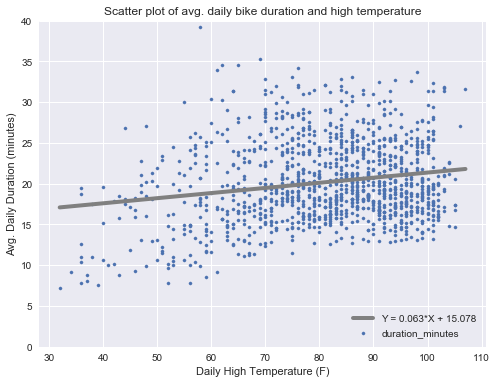

Pearson:  0.187304238268
Spearman:  0.123407216062 

Y = 0.063*X + 15.078


In [166]:
_df = get_merged_data(aggregation='mean')
_df = _df.dropna(subset=['duration_minutes'])

inter, slope = LeastSquares(_df['TempHighF'], _df['duration_minutes'])
fit_xs, fit_ys = FitLine(_df['TempHighF'], inter, slope)

plt.figure(figsize=(8, 6))
plt.scatter(_df['TempHighF'], _df['duration_minutes'], s=10)
plt.plot(fit_xs, fit_ys, color='gray', linewidth=4, 
         label='Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))

plt.title('Scatter plot of avg. daily bike duration and high temperature')
plt.ylabel('Avg. Daily Duration (minutes)')
plt.xlabel('Daily High Temperature (F)')
plt.ylim([0,40])
plt.legend(loc='lower right')
plt.show()

print('Pearson: ', _df[['TempHighF', 'duration_minutes']].corr().loc['TempHighF', 'duration_minutes'])
print('Spearman: ', _df[['TempHighF', 'duration_minutes']].corr(method='spearman').loc['TempHighF', 'duration_minutes'], '\n')
print('Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))


In [174]:
_df.corr().loc['duration_minutes']

duration_minutes              1.000000
TempHighF                     0.187304
TempAvgF                      0.163334
TempLowF                      0.127317
DewPointHighF                 0.126673
DewPointAvgF                  0.132159
DewPointLowF                  0.121939
HumidityHighPercent           0.036965
HumidityAvgPercent           -0.044935
HumidityLowPercent           -0.091646
SeaLevelPressureHighInches   -0.136702
SeaLevelPressureAvgInches    -0.117945
SeaLevelPressureLowInches    -0.097533
VisibilityHighMiles           0.056426
VisibilityAvgMiles            0.120896
VisibilityLowMiles            0.070379
WindHighMPH                  -0.024428
WindAvgMPH                   -0.039249
WindGustMPH                   0.014554
PrecipitationSumInches       -0.082092
Name: duration_minutes, dtype: float64

The correlation between daily average ride duration and daily high temperature is higher than the correlation between daily average ride duration and any other feature.

## What about regressing on number of bike rides per day

In [5]:
num_rides_df = pd.DataFrame(df['date'].value_counts())
num_rides_df.rename(columns={'date': 'num_rides'}, inplace=True)
num_rides_df = num_rides_df.join(weather_df)

inter, slope = LeastSquares(num_rides_df['TempHighF'], num_rides_df['num_rides'])
fit_xs, fit_ys = FitLine(num_rides_df['TempHighF'], inter, slope)

In [6]:
num_rides_df.corr().loc['num_rides']

num_rides                     1.000000
TempHighF                     0.190382
TempAvgF                      0.169681
TempLowF                      0.137697
DewPointHighF                 0.126555
DewPointAvgF                  0.136909
DewPointLowF                  0.145999
HumidityHighPercent           0.005386
HumidityAvgPercent           -0.051994
HumidityLowPercent           -0.078631
SeaLevelPressureHighInches   -0.145877
SeaLevelPressureAvgInches    -0.118144
SeaLevelPressureLowInches    -0.099767
VisibilityHighMiles           0.050644
VisibilityAvgMiles            0.118102
VisibilityLowMiles            0.091576
WindHighMPH                  -0.096742
WindAvgMPH                   -0.059832
WindGustMPH                  -0.086030
PrecipitationSumInches       -0.128239
Name: num_rides, dtype: float64

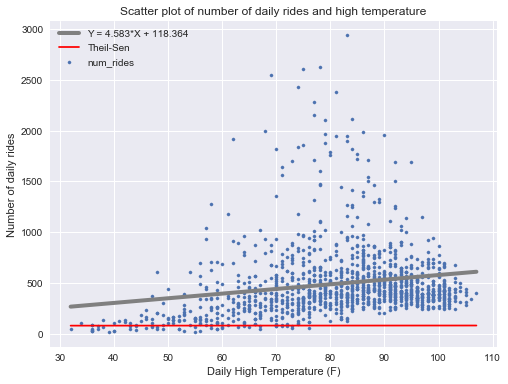

Pearson:  0.190381755854
Spearman:  0.280897250697 

Y = 4.583*X + 118.364


In [7]:
plt.figure(figsize=(8, 6))

plt.scatter(num_rides_df['TempHighF'], num_rides_df['num_rides'], s=10)
plt.plot(fit_xs, fit_ys, color='gray', linewidth=4,
        label='Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))
res = stats.theilslopes(num_rides_df['TempHighF'], num_rides_df['num_rides'], 0.90)
plt.plot(fit_xs, res[1] + res[0]*fit_xs, color='red',
        label='Theil-Sen')

plt.title('Scatter plot of number of daily rides and high temperature')
plt.ylabel('Number of daily rides')
plt.xlabel('Daily High Temperature (F)')
plt.legend(loc='upper left')
plt.show()

print('Pearson: ', num_rides_df[['TempHighF', 'num_rides']].corr().loc['TempHighF', 'num_rides'])
print('Spearman: ', num_rides_df[['TempHighF', 'num_rides']].corr(method='spearman').loc['TempHighF', 'num_rides'], '\n')
print('Y = {}*X + {}'.format(round(slope, 3), round(inter, 3)))
